# Pokemon Image Classification

> Training pipeline

In [ ]:
#hide
from fastai.vision.all import *
from fastai.callback.wandb import *
import wandb
from collections import OrderedDict
from notes.misc import *

In [ ]:
#hide
wandb.init(project='pokemon_image_classification')

## Data

In [ ]:
path = Path('images')
files = get_image_files(path)

In [ ]:
def img2rgb(img):
    return img.convert('RGB')

In [ ]:
datasets = Datasets(
    files,
    tfms=[[PILImage.create, img2rgb], [parent_label, Categorize]],
    splits=RandomSplitter()(files)
)

In [ ]:
dataloaders = datasets.dataloaders(
    after_item=[ToTensor, RandomResizedCrop(224)],
    after_batch=[IntToFloatTensor],
    bs=128,
)

### Preview data

Here's what the training data looks like.  Possibly some cases with bad labels.

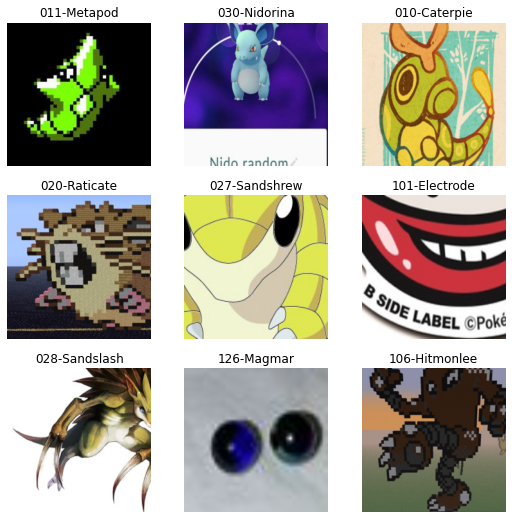

In [ ]:
dataloaders.show_batch()

## Model


### Architecture


In [ ]:
model = nn.Sequential(OrderedDict([
    ('body', create_body(xresnet50, cut=-4)),
    ('head', create_head(2048, 151, lin_ftrs=[2048]))
]))

### Training

In [ ]:
learner = Learner(
    dataloaders,
    model,
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, top_k_accuracy],
    cbs=[SaveModelCallback, WandbCallback]
)

In [ ]:
#hide
# learner.fine_tune(400)
learner = learner.load('model')

/home/andrew/miniconda3/envs/testeroni/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Actual training was 400 epochs

Only 1 cycle shown here for brevity

In [ ]:
# learner.fine_tune(1)

## Performance

In [ ]:
from experiments.utils import *

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
        
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
@patch
def show_activations(self: Learner, img):
    img = Path(img)
    pipeline = Pipeline([PILImage.create, ToTensor, Resize(224, method='squish'), IntToFloatTensor])
    x = pipeline(img).unsqueeze(0)
    y, name = img.parent.name.split('-')
    y = int(y)

    with HookBwd(learner.model.body) as hookg:
        with Hook(learner.model.body) as hook:
            output = learner.model.eval()(x)
            act = hook.stored
        output[0,y].backward()
        grad = hookg.stored


    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)

    
    _,ax = plt.subplots()
    x[0].show(ctx=ax)
    ax.title.set_text(name)
    ax.imshow(cam_map.detach().cpu(), alpha=0.80, extent=(0,224,224,0),
                  interpolation='sinc', cmap='magma_r')

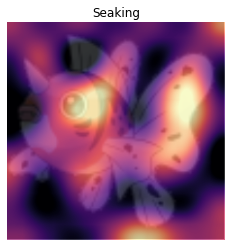

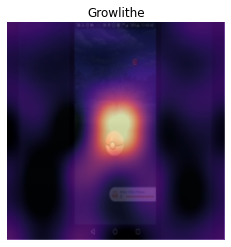

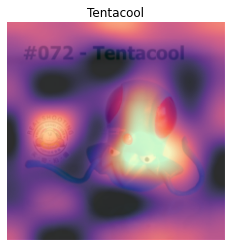

In [ ]:
for _ in range(3):
    learner.show_activations(random.choice(files))

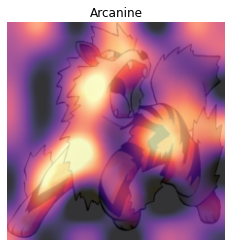

In [ ]:
learner.show_activations('images/059-Arcanine/Image_3.jpg')

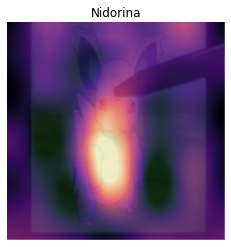

In [ ]:
learner.show_activations('images/030-Nidorina/Image_8.jpg')

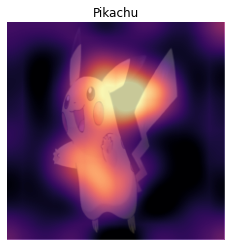

In [ ]:
learner.show_activations('images/025-Pikachu/Image_11.jpg')

## Performance

Classification results look good.  Many images are classified correctly, including variants like pencil drawings, 2d art, and crochet.

There are two labels which might be concerning:
1. 097-Hypno is actually a picture of Jimmy Neutron
2. 147-Dratini has multiple images of Dratini, Dragonair, and Dragonite

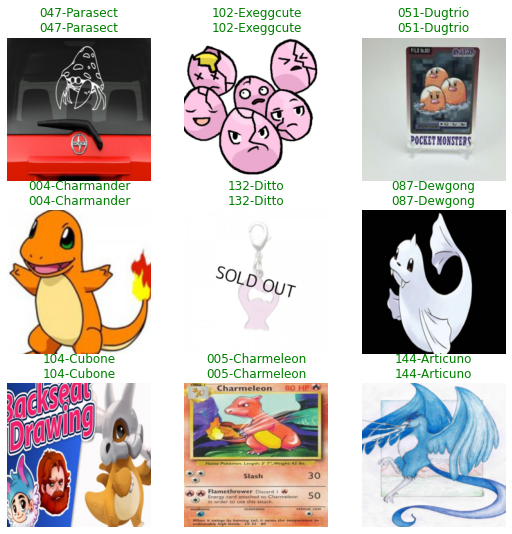

In [ ]:
learner.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

/home/andrew/miniconda3/envs/testeroni/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Top Losses

Interesting notes:
1. Some cases where wrong prediction is because of bad labels (e.g. "Sandslash" is actually buttons on a log or a broken pokeball)
2. Even when the label is wrong, the model made the correct prediction (e.g. "Mr.Mime" and "Kangaskhan")

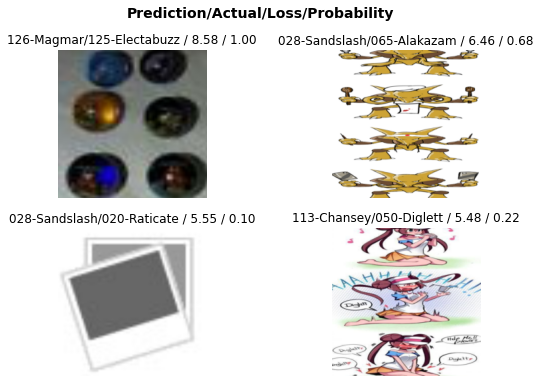

In [ ]:
interp.plot_top_losses(4, figsize=(9,6))

### Confusion Matrix

(hidden because of large size)

## Export Model

Need to explicitly remove `wandb` dependencies from learner

In [ ]:
# del learner.wandb
# learner.cbs = learner.cbs[:-2]

In [ ]:
# learner.export('pokemon_classification_model3')